In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
from catboost import CatBoostRegressor, Pool
%matplotlib inline

np.random.seed(12)

Загрузим и посмотрим на имеющтеся данные.

In [ ]:
data = pd.read_csv('data/data.csv', parse_dates=['Date'], dayfirst=True)
train = pd.read_csv('data/train.csv', parse_dates=['Date'], dayfirst=True)
test = pd.read_csv('data/test.csv', parse_dates=['Date'], dayfirst=True)
restaurants = pd.read_csv('data/restaurants.csv')

In [ ]:
data.head()

,City,Date,Temperature,Fuel_Price,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,8.106,False
1,1,2010-02-12,38.51,2.548,8.106,True
2,1,2010-02-19,39.93,2.514,8.106,False
3,1,2010-02-26,46.63,2.561,8.106,False
4,1,2010-03-05,46.50,2.625,8.106,False


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 0 to 3639
Data columns (total 6 columns):
City            3640 non-null int64
Date            3640 non-null datetime64[ns]
Temperature     3640 non-null float64
Fuel_Price      3640 non-null float64
Unemployment    3380 non-null float64
IsHoliday       3640 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 145.9 KB


In [9]:
data[data['Unemployment'].isna()]['Date'].min()

Timestamp('2013-05-03 00:00:00')

In [7]:
test['Date'].max()

Timestamp('2012-10-26 00:00:00')

В файле data в колонке Unemployment есть пропуски, но даты этих пропусков не присутствуют ни в train, ни в test, поэтому их можно игнорировать.

In [ ]:
restaurants.head()

,City,Size
0,1,151315
1,2,202307
2,3,37392
3,4,205863
4,5,34875


In [ ]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
City    20 non-null int64
Size    20 non-null int64
dtypes: int64(2)
memory usage: 448.0 bytes


В данных по городам пропусков нет.

In [ ]:
train.head()

,City,Restaurant,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137938 entries, 0 to 137937
Data columns (total 5 columns):
City            137938 non-null int64
Restaurant      137938 non-null int64
Date            137938 non-null datetime64[ns]
Weekly_Sales    137938 non-null float64
IsHoliday       137938 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 4.3 MB


В данных по ресторанам пропусков нет. Посмотрин на распределение Weekly_Sales.

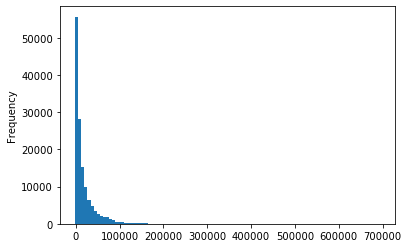

In [ ]:
train['Weekly_Sales'].plot.hist(bins=100)

Большенсво значений меньше 200000. Посмотрим на остальный значения более внимательно.

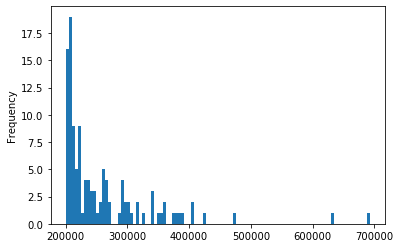

In [ ]:
train.query('Weekly_Sales > 200000')['Weekly_Sales'].plot.hist(bins=100);

В данных есть пара значений сильно отличающихся от остальных с значениями больше 600000. Скорее всего их можно считать выбросами. Удалим их.

In [ ]:
train = train.query('Weekly_Sales < 600000')

Данные представляют собой изменение прибыли рестаранов со временем, поэтому отсортируем данные по датам.

In [ ]:
train.sort_values('Date', inplace=True)

Если посмотреть на даты снятия данных у одного рестарана, то можно заметить, что они повторяются. Поэтому для уникального определения ресторана нужно использовать номер ресторана и города вместе.

In [11]:
train.query('Restaurant == 92')['Date'].value_counts()

2010-12-24    20
2011-07-22    20
2011-02-04    20
2010-07-16    20
2011-10-21    20
              ..
2011-12-23    20
2010-02-26    20
2011-06-03    20
2010-11-12    20
2010-06-04    20
Name: Date, Length: 100, dtype: int64

In [26]:
train.groupby(['City', 'Restaurant'])['Weekly_Sales'].describe()

count           mean  ...          75%        max
City Restaurant                        ...                        
1    1           100.0   22978.995300  ...   23509.4700   57258.43
     2           100.0   45899.561300  ...   47486.7125   65615.36
     3           100.0   12758.939500  ...   12093.9425   51159.17
     4           100.0   36570.254000  ...   37814.0400   47893.23
     5           100.0   25068.999000  ...   26686.0450   85676.09
...                ...            ...  ...          ...        ...
20   95          100.0  149705.708700  ...  158482.8975  184591.99
     96            2.0      -1.240000  ...       2.3600       5.96
     97          100.0   25594.340200  ...   28311.2050   33639.52
     98          100.0   19374.990700  ...   20365.4050   28265.62
     99           17.0    1558.236471  ...     660.0000   12550.00

[1522 rows x 8 columns]

В таблице видно, что при такой группировке минимальное, среднее и максимальное значения Weekly_Sales у рестаранов не сильно отличаются.

Посмотрим на график дохода отдельных ресторанов.

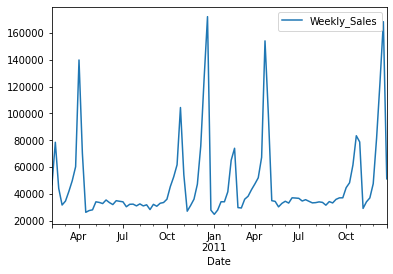

In [ ]:
train.query('City==13 and Restaurant == 1').plot.line('Date', 'Weekly_Sales');

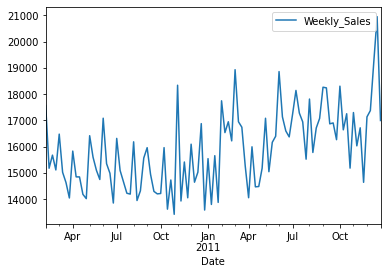

In [12]:
train.query('City==3 and Restaurant==2').plot.line('Date', 'Weekly_Sales');

На первом графике доход ресторана сильно зависит от месяца. Это можно будет использовать как дополнительный признак.

Объединим train, data и restaurants в одну таблицу.

In [ ]:
def merge_data(df, data, restaurants):
    new_data = df.merge(data.drop('IsHoliday', axis=1), 'left', ['City', 'Date'])
    new_data = new_data.merge(restaurants, 'left', 'City')
    new_data['IsHoliday'] = new_data['IsHoliday'].astype(int)
    return new_data

In [28]:
train_data = merge_data(train, data, restaurants)
train_data.head()

,City,Restaurant,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,Unemployment,Size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,8.106,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,8.106,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,8.106,151315
3,1,1,2010-02-26,19403.54,0,46.63,2.561,8.106,151315
4,1,1,2010-03-05,21827.90,0,46.50,2.625,8.106,151315


Обучим первую модель как начальную точку для сравнения улучшений. Используем градиентный бустинг, а именно CatBoosterRegressor. Модели градиентного бустинга показывают хорошие результаты на множестве задач и их также применяют для задач регрессии.  Одним из плюсов CatBoosterRegressor является возможность посмотреть на важность признаков, что может помочь понять куда двигаться дальше. Для CatBoostRegressor категориальные признаки не нужно кодировать, их можно, просто, указать при обучении можели.

In [ ]:
CATEGORICAL_FEATURES = ['City', 'Restaurant']

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop(['Weekly_Sales', 'Date'], 1), train_data['Weekly_Sales'], train_size=.8)
train_pool = Pool(X_train, y_train, cat_features=CATEGORICAL_FEATURES)
valid_pool = Pool(X_valid, y_valid, cat_features=CATEGORICAL_FEATURES)

In [32]:
cbr_base = CatBoostRegressor(random_seed=12, iterations=2000, od_type='Iter', od_wait=30, use_best_model=True)
cbr_base.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.072783
0:	learn: 24635.6626404	test: 25000.7631682	best: 25000.7631682 (0)	total: 48.9ms	remaining: 1m 37s
1:	learn: 23741.0439038	test: 24097.8561307	best: 24097.8561307 (1)	total: 83.5ms	remaining: 1m 23s
2:	learn: 22936.6797978	test: 23283.7233052	best: 23283.7233052 (2)	total: 115ms	remaining: 1m 16s
3:	learn: 22216.3933042	test: 22560.5363470	best: 22560.5363470 (3)	total: 150ms	remaining: 1m 14s
4:	learn: 21591.8390499	test: 21934.2004808	best: 21934.2004808 (4)	total: 184ms	remaining: 1m 13s
5:	learn: 21001.2316789	test: 21331.0308420	best: 21331.0308420 (5)	total: 214ms	remaining: 1m 11s
6:	learn: 20479.9323991	test: 20799.2200027	best: 20799.2200027 (6)	total: 245ms	remaining: 1m 9s
7:	learn: 20044.6911747	test: 20357.8986902	best: 20357.8986902 (7)	total: 275ms	remaining: 1m 8s
8:	learn: 19663.5578935	test: 19964.9764153	best: 19964.9764153 (8)	total: 314ms	remaining: 1m 9s
9:	learn: 19219.7311576	test: 19513.6740987	best: 19513.6740987 (9)	total: 358ms

Посмотрим на различия предсказанных и истинных значений.

In [ ]:
predicted = cbr_base.predict(valid_pool)

Text(0, 0.5, 'Predicted values')

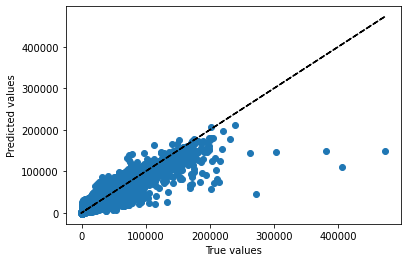

In [34]:
plt.scatter(y_valid, predicted);
plt.plot(y_valid, y_valid, '--k')
plt.xlabel('True values')
plt.ylabel('Predicted values')

Точки, в основном, концентрируются вокруг линии, но не очень плотно. Более большие значения значительно отдаляются.
Посмотрим на важность признаков.

In [35]:
for score, name in sorted(zip(cbr_base.feature_importances_, X_train.columns), reverse=True):
    print(f'{name}: {score}')

Restaurant: 47.56213571432082
City: 15.91009577808447
Size: 13.230118940134702
Temperature: 7.788557142934623
Unemployment: 7.685620182404443
Fuel_Price: 6.870088697104672
IsHoliday: 0.9533835450165192


Попробуем улучшить качество предсказаний с помощью добавления новых признаков. В качестве новых признаков можно добавить:
- **Month** и **Day** - мы не можем напрямую использовать дату, поэтому введем отдельно номер дня и месяца. Год добавлять нет смысла, так как нам надо будет предсказывать значения для последующих годов;
- **Week** - так как данные снимаются по недялям, то номер недели может иметь значение;
- **Mean**, **Min**, **Max**, **Median** - у ресторанов может сильно отличается прибыль, поэтому чтобы отобразить это добавим признаки, связанные с этим.

In [36]:
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day
train_data['Week'] = train_data['Date'].dt.week
train_data['Mean'] = train_data.groupby(['City', 'Restaurant'])['Weekly_Sales'].transform('mean')
train_data['Min'] = train_data.groupby(['City', 'Restaurant'])['Weekly_Sales'].transform('min')
train_data['Max'] = train_data.groupby(['City', 'Restaurant'])['Weekly_Sales'].transform('max')
train_data['Median'] = train_data.groupby(['City', 'Restaurant'])['Weekly_Sales'].transform('median')
train_data.head()

,City,Restaurant,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,Unemployment,Size,Month,Day,Week,Mean,Min,Max,Median
0,1,1,2010-02-05,24924.50,0,42.31,2.572,8.106,151315,2,5,5,22978.9953,14537.37,57258.43,18988.7
1,1,1,2010-02-12,46039.49,1,38.51,2.548,8.106,151315,2,12,6,22978.9953,14537.37,57258.43,18988.7
2,1,1,2010-02-19,41595.55,0,39.93,2.514,8.106,151315,2,19,7,22978.9953,14537.37,57258.43,18988.7
3,1,1,2010-02-26,19403.54,0,46.63,2.561,8.106,151315,2,26,8,22978.9953,14537.37,57258.43,18988.7
4,1,1,2010-03-05,21827.90,0,46.50,2.625,8.106,151315,3,5,9,22978.9953,14537.37,57258.43,18988.7


Обучим модель на новых признаках.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop(['Weekly_Sales', 'Date'], 1), train_data['Weekly_Sales'], train_size=.8)
train_pool = Pool(X_train, y_train, cat_features=CATEGORICAL_FEATURES)
valid_pool = Pool(X_valid, y_valid, cat_features=CATEGORICAL_FEATURES)

In [38]:
cbr_1 = CatBoostRegressor(random_seed=12, iterations=2000, od_type='Iter', od_wait=30, use_best_model=True)
cbr_1.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.072783
0:	learn: 24037.0208135	test: 24462.0049962	best: 24462.0049962 (0)	total: 71.4ms	remaining: 2m 22s
1:	learn: 22556.3664562	test: 22934.6333306	best: 22934.6333306 (1)	total: 139ms	remaining: 2m 18s
2:	learn: 21225.2911084	test: 21576.8341043	best: 21576.8341043 (2)	total: 221ms	remaining: 2m 27s
3:	learn: 19980.7440496	test: 20305.6451646	best: 20305.6451646 (3)	total: 291ms	remaining: 2m 25s
4:	learn: 18838.1562661	test: 19146.3291142	best: 19146.3291142 (4)	total: 360ms	remaining: 2m 23s
5:	learn: 17790.5983599	test: 18068.9563441	best: 18068.9563441 (5)	total: 437ms	remaining: 2m 25s
6:	learn: 16835.0795919	test: 17087.3160027	best: 17087.3160027 (6)	total: 505ms	remaining: 2m 23s
7:	learn: 15929.7345395	test: 16156.3167374	best: 16156.3167374 (7)	total: 571ms	remaining: 2m 22s
8:	learn: 15129.8458102	test: 15333.6165605	best: 15333.6165605 (8)	total: 636ms	remaining: 2m 20s
9:	learn: 14377.1766176	test: 14561.1331580	best: 14561.1331580 (9)	total: 705

Посмотрим на различия предсказанных и истинных значений.

In [ ]:
predicted = cbr_1.predict(valid_pool)

Text(0, 0.5, 'Predicted values')

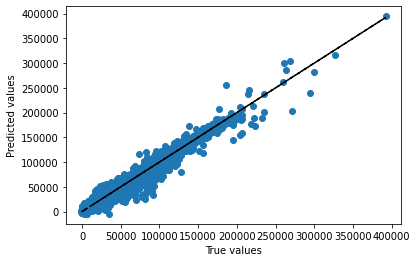

In [40]:
plt.scatter(y_valid, predicted);
plt.plot(y_valid, y_valid, '--k')
plt.xlabel('True values')
plt.ylabel('Predicted values')

Точки группируются намного ближе к линии.

In [41]:
for score, name in sorted(zip(cbr_1.feature_importances_, X_train.columns), reverse=True):
    print(f'{name}: {score}')

Mean: 28.72280096654262
Median: 17.622306364517097
Week: 15.336477216081366
Max: 14.940546259808436
Min: 8.759245231992828
Day: 3.473833297393014
Month: 3.140384670470398
Restaurant: 2.838412100691759
Temperature: 1.7547294866524072
IsHoliday: 1.3201308282328768
Fuel_Price: 0.7400325872656964
Unemployment: 0.6932027999160318
Size: 0.43729633911412147
City: 0.22060185132120885


In [43]:
cbr_1.learning_rate_

0.07278300076723099

Ошибка модели продолжает мадать. Увеличим количество итераций и learning_rate.

In [56]:
cbr_2 = CatBoostRegressor(random_seed=12, iterations=3000, od_type='Iter', od_wait=30, use_best_model=True, learning_rate=.3)
cbr_2.fit(train_pool, eval_set=valid_pool)

0:	learn: 19337.5840398	test: 19118.3788768	best: 19118.3788768 (0)	total: 69.5ms	remaining: 3m 28s
1:	learn: 15122.0725457	test: 14951.2630440	best: 14951.2630440 (1)	total: 138ms	remaining: 3m 26s
2:	learn: 12231.3412182	test: 12100.6666290	best: 12100.6666290 (2)	total: 202ms	remaining: 3m 21s
3:	learn: 10231.6250275	test: 10178.5301408	best: 10178.5301408 (3)	total: 266ms	remaining: 3m 19s
4:	learn: 9020.5869496	test: 9005.1698274	best: 9005.1698274 (4)	total: 334ms	remaining: 3m 19s
5:	learn: 8287.9028106	test: 8286.0684558	best: 8286.0684558 (5)	total: 399ms	remaining: 3m 18s
6:	learn: 7738.2492142	test: 7749.3149830	best: 7749.3149830 (6)	total: 470ms	remaining: 3m 21s
7:	learn: 7463.0273346	test: 7479.1554028	best: 7479.1554028 (7)	total: 543ms	remaining: 3m 23s
8:	learn: 7136.9977645	test: 7115.6004322	best: 7115.6004322 (8)	total: 609ms	remaining: 3m 22s
9:	learn: 6863.8511740	test: 6887.6409508	best: 6887.6409508 (9)	total: 677ms	remaining: 3m 22s
10:	learn: 6735.1889963	tes

Качество модели перестало увеличиваться с обучением.

In [ ]:
predicted = cbr_2.predict(valid_pool)

Text(0, 0.5, 'Predicted values')

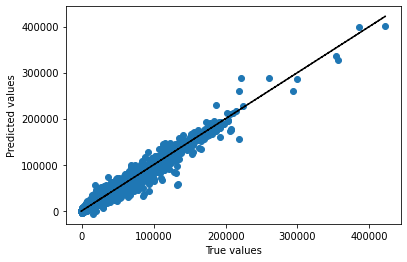

In [58]:
plt.scatter(y_valid, predicted);
plt.plot(y_valid, y_valid, '--k')
plt.xlabel('True values')
plt.ylabel('Predicted values')

Точки группируются намного ближе к линии. Обучим модель на всех данных и используем ее для предсказания будущих данных.

In [65]:
cbr_final = CatBoostRegressor(random_seed=12, iterations=3000, od_type='Iter', od_wait=30, learning_rate=.3)
all_data_pool = Pool(train_data.drop(['Weekly_Sales', 'Date'], 1), train_data['Weekly_Sales'], cat_features=CATEGORICAL_FEATURES)
cbr_final.fit(all_data_pool)

0:	learn: 19365.2395213	total: 84.4ms	remaining: 4m 13s
1:	learn: 15069.0262492	total: 160ms	remaining: 4m
2:	learn: 12160.2214020	total: 246ms	remaining: 4m 5s
3:	learn: 10393.6705709	total: 324ms	remaining: 4m 2s
4:	learn: 9366.3302799	total: 395ms	remaining: 3m 56s
5:	learn: 8473.8385709	total: 472ms	remaining: 3m 55s
6:	learn: 7901.4471610	total: 557ms	remaining: 3m 58s
7:	learn: 7615.9190729	total: 633ms	remaining: 3m 56s
8:	learn: 7227.5614967	total: 710ms	remaining: 3m 55s
9:	learn: 6997.1321792	total: 792ms	remaining: 3m 56s
10:	learn: 6904.2131471	total: 872ms	remaining: 3m 56s
11:	learn: 6796.8230538	total: 946ms	remaining: 3m 55s
12:	learn: 6577.3462662	total: 1.02s	remaining: 3m 55s
13:	learn: 6471.1974186	total: 1.1s	remaining: 3m 54s
14:	learn: 6369.4322405	total: 1.17s	remaining: 3m 53s
15:	learn: 6320.4450980	total: 1.26s	remaining: 3m 54s
16:	learn: 6292.2442731	total: 1.33s	remaining: 3m 53s
17:	learn: 6152.0866525	total: 1.41s	remaining: 3m 53s
18:	learn: 6089.618790

Преобразуем тестовые данные таким же образом как и тренировачные. Mean, Min, Max, Median возьмем из соответствующих ресторанов в train_data.

In [84]:
test_data = merge_data(test, data, restaurants)
test_data['Month'] = test_data['Date'].dt.month
test_data['Day'] = test_data['Date'].dt.day
test_data['Week'] = test_data['Date'].dt.week
test_data = pd.merge(
    test_data, 
    train_data[['City', 'Restaurant', 'Mean', 'Min', 'Max', 'Median']].drop_duplicates(), 
    'left',
    ['City', 'Restaurant']
    )
test_data.drop('Date', 1, inplace=True)
test_data.head()

,City,Restaurant,IsHoliday,Temperature,Fuel_Price,Unemployment,Size,Month,Day,Week,Mean,Min,Max,Median
0,1,1,0,49.01,3.157,7.348,151315,1,6,1,22978.9953,14537.37,57258.43,18988.7
1,1,1,0,48.53,3.261,7.348,151315,1,13,2,22978.9953,14537.37,57258.43,18988.7
2,1,1,0,54.11,3.268,7.348,151315,1,20,3,22978.9953,14537.37,57258.43,18988.7
3,1,1,0,54.26,3.290,7.348,151315,1,27,4,22978.9953,14537.37,57258.43,18988.7
4,1,1,0,56.55,3.360,7.348,151315,2,3,5,22978.9953,14537.37,57258.43,18988.7


Получим предсказания и запишем их в файл.

In [ ]:
weekly_sales = cbr_final.predict(test_data)
weekly_sales = pd.Series(weekly_sales.reshape((-1,)), name='Weekly_Sales')
submission = pd.concat((test, weekly_sales), 1)
submission['Date'] = submission['Date'].dt.strftime('%d-%m-%y')
submission.to_csv('submission.csv', index=False)

In [87]:
submission.head()

,City,Restaurant,Date,IsHoliday,Weekly_Sales
0,1,1,06-01-12,False,19293.604798
1,1,1,13-01-12,False,19868.795468
2,1,1,20-01-12,False,19478.531014
3,1,1,27-01-12,False,19157.801092
4,1,1,03-02-12,False,33320.685806
